# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

## MLP Makemore implementation

Paper source: [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), this paper doing word prediction. This implementation stick to character predicition.

Paper breakdown:
- This paper embbeds each word from vocabulary (17000 words) to 30, 60 or 100 dimensional feature vector
- Each 17000 words embedded randomly to 30 feature vectors, then the embedding would be tuned using backpropagation.
- Words that has similar meaning would ended up in similar position in the dimensional space
- Modeling approach -> Multi linear neural network to predict the next word given the previous ones
- Training -> maximize the log likelihood of the training data

**Structure of the model**

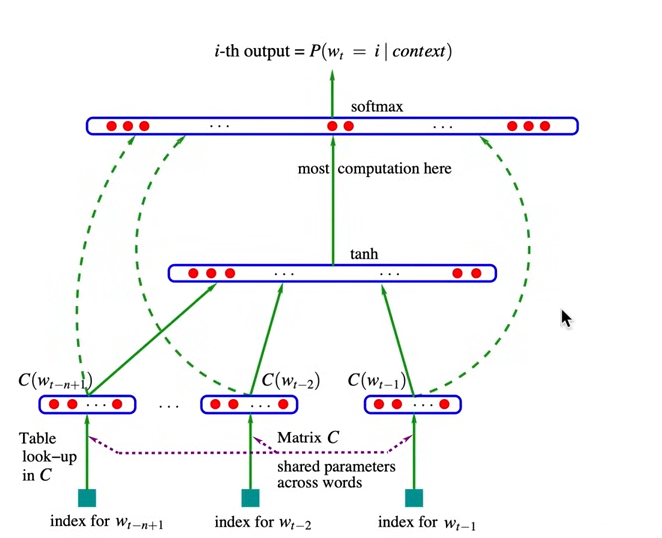

Figure explanation:

- Input part (3 words)
    - Taking 3 previous word and predict the fourth word
    - Each word -> 17000 possible word (vocabulary) and the index is int of 0-16999
    - There is a look-up table/embedding matrix C sized 17000 x 30 (17000 word and 30 dimension)
    - Setiap index word ngambil baris dari embedding matrix C. Each index converted to 30 dimension
    - Matrix C is shared across word, so there is 1 embedding matrix C and used to those 3 index
- Fully-connected hidden layer (tanh)
    - Size of the neural net is a hyperparameter, so we can choose the size by ourself
- Output layer (softmax)
    - There are 17000 words that could come next, so the number of the output layer is 17000 and all fully connected to hidden layer
    - The expensive layer

Parameters optimized using backpropagation:
- Weights and Biases on the layers
- Look up table

Parameters is optimized by trying to maximize the probability of the label word (the next word) with the respect of the NN parameters

In [509]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset and Building vocabulary

The included `names.txt` dataset, as an example, has the most common 32K names takes from [ssa.gov](https://www.ssa.gov/oact/babynames/) for the year 2018.

In [510]:
# Open the dataset (List of names) as a python list of strings which is words in this case
word= open('names.txt', 'r').read().splitlines()

In [511]:
#First 10 word
word[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [512]:
len(word)

32033

In [513]:
#Shortest word and longest word (word=names)
min(len(w) for w in word) , max(len(w) for w in word)

(2, 15)

Statistical sequence of characters -> names:

What char likely to start the sequence?

Whar char likely appear after given sequence of characters before it?

What char likely to appear at last of the character sequence?

In [514]:
#Building vocabulary
chars=sorted(list(set(''.join(word))))
stoi={c:i+1 for i,c in enumerate(chars)} #Mapping of character to index
stoi['.']=0 #Start/End token
itos={i:c for c,i in stoi.items()} #Mapping of index to character
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building dataset

In [515]:
#Breakdown of the dataset algorithm
block_size=3 #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
X, Y= [], []
for w in word[:1]: #First 5 words
    print(w)
    context=[0]*block_size 
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print (''.join(itos[i] for i in context), '-->', itos[ix])
        context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .


3 char --> label char

context --> label

Tensor dataset

In [516]:
block_size=3 #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
X, Y= [], []
for w in word:
    # print(w)
    context=[0]*block_size #Padded context of 0 tokens -> [0]* 3 = [0,0,0] -> . . .
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print (''.join(itos[i] for i in context), '-->', itos[ix])
        context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx
#Convert to tensor
X= torch.tensor(X)
Y= torch.tensor(Y)

In [517]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

X ->int64-> [228146, 3] -> 228146 examples (data) and each input to NN is 3 int

Y ->int64-> [228146] -> int label

In [518]:
#Sample of the dataset
X[:32], Y[:32]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

#### Building Embedding table C and input part
There are 27 possible characters in the dataset and embbed it to low dimensional space

Paper -> 17000 words, embbed as small as 30 dimension

Our case there are 27 characters, embbed as small as 2 dimension (example) -> 27 x 2

In [519]:
# Look up table contains random numbers first
C= torch.randn((27,2))
C.dtype

torch.float32

Try to embbed 1 example -> int 5 and comparing 2 methods, using matrix multiply (one_hot encoding) and access it via index

In [520]:
# One hot encoding
# Careful this error
# ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# Cell In[27], line 1
# ----> 1 F.one_hot(5, num_classes=27)

# TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int

F.one_hot(torch.tensor(5), num_classes=27).dtype, F.one_hot(torch.tensor(5), num_classes=27) #Fifth column assigned as 1

(torch.int64,
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]))

In [521]:
C[5] #Access via index to row 5

tensor([-1.2948, -0.3267])

In [522]:
F.one_hot(torch.tensor(5), num_classes=27).shape, C.shape
# (27,) -> 1D tensor -> broadcasted to (1,27)

(torch.Size([27]), torch.Size([27, 2]))

In [523]:
# Torch does not know how to do matrix multiplication between int and float
#Convert one_hot result to float first
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.2948, -0.3267])

We get same result

Because how matrix multiplication is like this

one hot encoded vector rows multiplied with columns of C

Nah pas perkalian itu di encoded vector kan ada 0, jadi otomatis bersihin value matrix C yang kena kali ama 0 itu, terus sisa value yang dikali ama 1 dari encoded vector (this case is row 5)

From that example, kita bisa nganggep bagian input sebagai layer pertama yang linear, dengan x itu inputnya dan weightnya itu matrix embedding C

Approach will be used is indexing because it is faster

### Embed all char

How to embed all char(which as int now) secara bersamaan di array X

Luckily the indexing in torch is very flexible, we can do indexing not just by passing a int but we can pass list as well

In [524]:
C[[5,6,7]] #Access multiple rows via list

tensor([[-1.2948, -0.3267],
        [-0.8854,  1.8037],
        [-0.3998,  0.3866]])

In [525]:
C[torch.tensor([5,6,7])] #Access multiple rows via tensor

tensor([[-1.2948, -0.3267],
        [-0.8854,  1.8037],
        [-0.3998,  0.3866]])

In [526]:
C[[7,7,7,7]] #Repeated access

tensor([[-0.3998,  0.3866],
        [-0.3998,  0.3866],
        [-0.3998,  0.3866],
        [-0.3998,  0.3866]])

Also we can index using multidimentional tensor like X is ([228146,3]) dim

Example

In [527]:
X[13,2]

tensor(1)

In [528]:
C[1], C[X][13,2] #Equals 

(tensor([0.9785, 0.5996]), tensor([0.9785, 0.5996]))

Create embedding

In [529]:
emb=C[X]

In [530]:
emb

tensor([[[ 0.6530,  0.2207],
         [ 0.6530,  0.2207],
         [ 0.6530,  0.2207]],

        [[ 0.6530,  0.2207],
         [ 0.6530,  0.2207],
         [-1.2948, -0.3267]],

        [[ 0.6530,  0.2207],
         [-1.2948, -0.3267],
         [ 0.1871,  1.0927]],

        ...,

        [[ 0.4202,  0.2994],
         [ 0.4202,  0.2994],
         [-1.5828, -0.9971]],

        [[ 0.4202,  0.2994],
         [-1.5828, -0.9971],
         [ 0.4202,  0.2994]],

        [[-1.5828, -0.9971],
         [ 0.4202,  0.2994],
         [ 2.7038,  0.1942]]])

In [531]:
emb.shape

torch.Size([228146, 3, 2])

### Building Hidden Layer

In [532]:
#Setting parameter, weight initialization random
# emb.shape is ([228146, 3, 2]) so the input to the weight is 3 x 2 =6
W1= torch.randn((6,100)) #100 layer
b1= torch.randn(100)

But we cannot directly multiply W1 to the emb since the dimension is not supported for matrix multiply

We need to transform [228146, 3, 2] to [228146, 6]. There are many ways

Concatenate Operation

Less efficient, it will creating new memory in storage

In [533]:
# Concatenate [First word , Second word, Third word as input in a sequence] -> 3 words as context, if there are more context, add more
torch.cat([emb[:,0,:] , emb[:,1,:] , emb[:,2,:]], dim=1).shape #Concatenate across dimension which is column

# Weakness= If the context size changes (the sequence of word), we need to change the code one by one manually

torch.Size([228146, 6])

In [534]:
# Fixing the weakness by using unbind function
# Unbind function is like split function in python
# Unbind function will split the tensor into list of tensors
# In this case, emb is split into 3 tensors
# Then, we can concatenate the list of tensors
# The context size can be changed easily
len(emb.unbind(dim=1)) #-> [emb[:,0,:] , emb[:,1,:] , emb[:,2,:],...]

3

In [535]:
torch.cat(emb.unbind(dim=1), dim=1).shape

torch.Size([228146, 6])

View Function

Basically torch stores all numbers in 1 dimension vector and interpret the dimension accordingly, it doesn't store the interpretation of the dimension in the storage. We can utilize this

In [536]:
emb.shape

torch.Size([228146, 3, 2])

In [537]:
emb.view(-1,6).shape #same as emb.view(228146,6) and same as the function before
# -1 means torch will determine the size of the dimension automatically

torch.Size([228146, 6])

In [538]:
emb.view(-1,6)[:5]

tensor([[ 0.6530,  0.2207,  0.6530,  0.2207,  0.6530,  0.2207],
        [ 0.6530,  0.2207,  0.6530,  0.2207, -1.2948, -0.3267],
        [ 0.6530,  0.2207, -1.2948, -0.3267,  0.1871,  1.0927],
        [-1.2948, -0.3267,  0.1871,  1.0927,  0.1871,  1.0927],
        [ 0.1871,  1.0927,  0.1871,  1.0927,  0.9785,  0.5996]])

dimension 3 and 2 are stacked the 1 row so making it 6

In [539]:
emb.view(-1,6) == torch.cat(torch.unbind(emb, dim=1), dim=1) #All true

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

Implement the calculation in NN

In [540]:
hh=emb.view(-1,6) @ W1 + b1 #Don't forget to make sure the broadcasting is correct 
hh

tensor([[-1.9126, -0.8537,  3.4387,  ...,  0.2588, -1.5707, -2.0558],
        [ 2.3956, -0.5287,  1.1303,  ...,  1.5214, -2.2758, -0.0802],
        [ 2.4103, -3.9009,  2.6308,  ...,  3.7944,  0.5558,  2.2172],
        ...,
        [ 3.0885, -0.4525,  0.3443,  ...,  0.7026, -3.4383,  0.0810],
        [ 1.2095, -3.9825,  0.9862,  ...,  2.1120, -0.4076,  1.2785],
        [-4.9086,  1.4695,  0.8413,  ..., -4.0801,  0.8680, -3.6939]])

In [541]:
h=torch.tanh(emb.view(-1,6) @ W1 + b1 )

In [542]:
h.shape

torch.Size([228146, 100])

### Building the output layer

In [543]:
W2= torch.randn((100,27)) #27 is the number of classes
b2= torch.randn(27)

In [544]:
logits=h @ W2 + b2

In [545]:
#Softmax
counts= logits.exp()
prob= counts / counts.sum(1, keepdim=True)

In [546]:
prob.shape

torch.Size([228146, 27])

In [547]:
prob[0].sum() #Ok it is normalized

tensor(1.)

### Building loss function

In [548]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [549]:
X.shape[0]

228146

In [550]:
#Taking the output, jadi liat aja yang harusnya punya probability tinggi yang mana, tarik aja probabilitynya yang berada di index sesuai di label Y (isinya angka index buat huruf)
prob[torch.arange(X.shape[0]), Y] #first index is 228146 -> the number of samples, second index is Y -> the target output

tensor([8.2517e-07, 8.2658e-08, 8.2306e-07,  ..., 2.6523e-01, 1.0249e-06,
        2.2044e-13])

dan hancur hasilnya

Negative log likelihood

In [551]:
loss=-prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(15.5085)

Basically it is a classification so we can use **cross entropy** which based on softmax function.

It will output the same result and more efficient

In [552]:
losses=F.cross_entropy(logits, Y)
losses

tensor(15.5085)

Why more efficient?

We don't need that many operation each step to get the loss, since when we do the operation we create another new tensor in the memory

Torch will cluster up those operation and create fused kernel that efficiently evaluate the expression

For the backward pass, it will more efficient because of the fused kernel and mathematically it is simpler function to deal with than each step operation before.

Cross entropy can be numerically more well behaved in some situation

In [553]:
#Example problem in the code before cross entropy
logitss=torch.tensor([-100, 100])
logitss.exp() , logitss.exp()/logitss.exp().sum()
#There is the problem with the exp part since when we give it a very large positive number (e^100), it will return infinity and the probability will be "nan"
#But when it is very negative it is fine 

(tensor([3.7835e-44,        inf]), tensor([0., nan]))

The way torch solve this problem is like this

In [554]:
#Changing for reasonable number
logitss=torch.tensor([-5, -3, 0 ,5])
logitss.exp() , "After Softmax", logitss.exp()/logitss.exp().sum()

(tensor([6.7379e-03, 4.9787e-02, 1.0000e+00, 1.4841e+02]),
 'After Softmax',
 tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01]))

In [555]:
#Sebenernya karena ini probabilitas outputnya (udah normalized) jadi kita kalau modif modif angkanya akan sama
#Kita bisa coba modif angka angka di logitss dan lihat hasilnya
logitss=torch.tensor([-5, -3, 0 ,5]) +10
logitss.exp() , "After Softmax", logitss.exp()/logitss.exp().sum()

(tensor([1.4841e+02, 1.0966e+03, 2.2026e+04, 3.2690e+06]),
 'After Softmax',
 tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01]))

In [556]:
logitss=torch.tensor([-5, -3, 0 ,5]) -3
logitss.exp() , "After Softmax", logitss.exp()/logitss.exp().sum()

(tensor([3.3546e-04, 2.4788e-03, 4.9787e-02, 7.3891e+00]),
 'After Softmax',
 tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01]))

Jadi torch bakal otomatis kalkulasi nilai max yang ada di logits itu dan kurangin logits berdasarkan max itu

In [557]:
logitss=torch.tensor([-5, -3, 0 ,5]) -5
logitss.exp() , "After Softmax", logitss.exp()/logitss.exp().sum()

(tensor([4.5400e-05, 3.3546e-04, 6.7379e-03, 1.0000e+00]),
 'After Softmax',
 tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01]))

In [558]:
logitss=torch.tensor([-5, -3, 0 ,100])
logitss.exp() , "After Softmax", logitss.exp()/logitss.exp().sum()

(tensor([0.0067, 0.0498, 1.0000,    inf]),
 'After Softmax',
 tensor([0., 0., 0., nan]))

In [559]:
#After fix
logitss=torch.tensor([-5, -3, 0 ,100]) -100
logitss.exp() , "After Softmax", logitss.exp()/logitss.exp().sum()

(tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]),
 'After Softmax',
 tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]))

### Model Summary

In [560]:
parameters=[C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) #jumlah parameter model

3481

In [561]:
parameters

[tensor([[ 0.6530,  0.2207],
         [ 0.9785,  0.5996],
         [-1.5665,  1.2337],
         [-0.8101, -0.8020],
         [ 0.6384,  1.3498],
         [-1.2948, -0.3267],
         [-0.8854,  1.8037],
         [-0.3998,  0.3866],
         [ 1.2590,  0.9319],
         [-0.5747,  0.5159],
         [ 0.4041, -2.1262],
         [ 0.4820, -0.5417],
         [ 0.3070,  0.5593],
         [ 0.1871,  1.0927],
         [ 1.5498, -0.2265],
         [ 0.7142,  3.0975],
         [ 0.6243, -2.3036],
         [ 1.8853,  1.6195],
         [-1.4109, -0.1833],
         [ 0.9654,  0.2578],
         [-0.0848,  1.3292],
         [-0.7332,  0.2630],
         [-0.2675,  0.4249],
         [ 0.8516,  0.6245],
         [ 2.7038,  0.1942],
         [-1.5828, -0.9971],
         [ 0.4202,  0.2994]]),
 tensor([[-7.5069e-02, -1.1976e+00,  7.1854e-01,  1.3140e-01,  1.7853e+00,
          -8.4246e-01, -4.5165e-01,  1.4837e+00,  2.0765e+00,  9.8336e-01,
           2.7527e-01, -8.2540e-02,  2.4504e-02,  1.3910e+00,  1.

### Backward Pass and Model training

In [562]:
# Reset Weight
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [W1, b1, W2, b2]

In [563]:
# Ensure all parameters require gradients (Use this code before computing forward pass)
for p in parameters:
    p.requires_grad = True

#Model Training
for i in range (50): #The training is slow for those 220k
    # Forward pass
    emb = C[X] #(228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(228146, 100)
    logits = h @ W2 + b2 #(228146, 27)
    loss = F.cross_entropy(logits, Y) #Cross entropy loss
    
    if i % 10 == 0:
        print(f'Loss {i}= ', loss.item())
    for p in parameters:
        p.grad=None
    # Backward pass
    loss.backward()

    #Update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

Loss 0=  16.701467514038086
Loss 10=  11.077178001403809
Loss 20=  8.727954864501953
Loss 30=  7.457665920257568
Loss 40=  6.705928325653076


We cannot achieve 0 loss since there are various outcomes from exact same input

In [564]:
logits.max(1) #Max value and index

torch.return_types.max(
values=tensor([ 3.6270,  5.0545,  7.0250,  ...,  4.3184,  7.4664, 11.7056],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 12,  9,  ..., 12, 15,  0]))

In [565]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

#### Making model training faster

##### Mini batch approach

We doing way too much calculation for 220k data, so we make the forward, backward, and update in batch

Randomly select some portion of the data (Mini-Batch), and doing training based on that batch

In [566]:
torch.randint(0,X.shape[0],(32,)) # generate between 0 to the size of the dataset and there are 32 of them (tuple)

tensor([167744,  19438, 180577, 102698, 207078, 153018, 150640,  50970,   8373,
        106090, 220633,  21903, 137293, 109843,  44817, 216889, 165808, 163155,
         30283, 180920, 211142,  14327,  16094, 131482,  37849, 227447,   9323,
        222892, 221420, 192510, 187003,  42310])

In [567]:
# Reset Weight
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [W1, b1, W2, b2]

In [568]:
# Ensure all parameters require gradients (Use this code before computing forward pass)
for p in parameters:
    p.requires_grad = True

#Model Training
for i in range (1000): #It will run instant and we can make the loss drop faster
    #Minibatch construct
    ix= torch.randint(0,X.shape[0],(32,))
    # Forward pass
    emb = C[X[ix]] #Take embedding of word that choosen by the randint ix
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) #Cross entropy loss, #Take label word that choosen by the randint ix
    
    if i % 10 == 0:
        print(f'Loss {i}= ', loss.item())
    for p in parameters:
        p.grad=None
    # Backward pass
    loss.backward()

    #Update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

Loss 0=  15.09554386138916
Loss 10=  11.94560432434082
Loss 20=  10.827679634094238
Loss 30=  8.49390983581543
Loss 40=  6.337507247924805
Loss 50=  5.672476768493652
Loss 60=  5.150866985321045
Loss 70=  5.577507019042969
Loss 80=  6.3648457527160645
Loss 90=  5.553271293640137
Loss 100=  4.673593044281006
Loss 110=  5.276916980743408
Loss 120=  4.829438209533691
Loss 130=  4.337378978729248
Loss 140=  4.316530704498291
Loss 150=  3.922842264175415
Loss 160=  4.39284086227417
Loss 170=  3.6552863121032715
Loss 180=  5.114574909210205
Loss 190=  3.7941431999206543
Loss 200=  4.825533866882324
Loss 210=  4.5191426277160645
Loss 220=  3.7488481998443604
Loss 230=  3.6828126907348633
Loss 240=  3.5786232948303223
Loss 250=  4.928280830383301
Loss 260=  3.760558605194092
Loss 270=  3.652977228164673
Loss 280=  4.229937553405762
Loss 290=  3.9450206756591797
Loss 300=  4.514640808105469
Loss 310=  3.5525028705596924
Loss 320=  2.8940207958221436
Loss 330=  3.313044548034668
Loss 340=  2.884

With this approach the quality of the gradient is not as good as non-batch approach since it is not the actual direction for the convergence (Approximate). But, the gradient direction is good enough to be useful

##### GPU TRAINING VERSION

In [570]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialization
W1 = torch.randn((6, 100), device=device, requires_grad=True)
b1 = torch.randn(100, device=device, requires_grad=True)
W2 = torch.randn((100, 27), device=device, requires_grad=True)
b2 = torch.randn(27, device=device, requires_grad=True)

parameters = [W1, b1, W2, b2]

# Move input data to the GPU
X = X.to(device)
Y = Y.to(device)
C=C.to(device)
emb = C[X].to(device)

# Model Training
for i in range(100):
    # Forward pass
    emb = C[X]  # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (228146, 100)
    logits = h @ W2 + b2  # (228146, 27)
    loss = F.cross_entropy(logits, Y)  # Cross entropy loss

    if i % 10 == 0:
        print(f'Loss {i}= ', loss.item())

    # Clear gradients
    for p in parameters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update the parameters
    for p in parameters:
            p.data -= 0.1 * p.grad

Loss 0=  13.619874954223633
Loss 10=  9.159323692321777
Loss 20=  7.488242149353027
Loss 30=  6.571298599243164
Loss 40=  5.9609503746032715
Loss 50=  5.527285099029541
Loss 60=  5.2104949951171875
Loss 70=  4.968881130218506
Loss 80=  4.777336597442627
Loss 90=  4.62069034576416


##### GPU TRAINING + MINI BATCH 

In [571]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialization
W1 = torch.randn((6, 100), device=device, requires_grad=True)
b1 = torch.randn(100, device=device, requires_grad=True)
W2 = torch.randn((100, 27), device=device, requires_grad=True)
b2 = torch.randn(27, device=device, requires_grad=True)


parameters = [W1, b1, W2, b2]

# Move input data to the GPU
X = X.to(device)
Y = Y.to(device)
C= C.to(device)
emb = C[X].to(device)

# Model Training
for i in range(10000):
    ix=torch.randint(0,X.shape[0],(32,))
    # Forward pass
    emb = C[X[ix]]  
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  
    logits = h @ W2 + b2  
    loss = F.cross_entropy(logits, Y[ix])  # Cross entropy loss

    if i % 10 == 0:
        print(f'Loss {i}= ', loss.item())

    # Clear gradients
    for p in parameters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update the parameters
    for p in parameters:
            p.data -= 0.1 * p.grad

Loss 0=  17.095212936401367
Loss 10=  8.96004581451416
Loss 20=  8.02966022491455
Loss 30=  6.776742935180664
Loss 40=  9.216180801391602
Loss 50=  6.276216506958008
Loss 60=  6.572206497192383
Loss 70=  6.120044708251953
Loss 80=  5.625454902648926
Loss 90=  5.100127220153809
Loss 100=  5.200736999511719
Loss 110=  4.829422950744629
Loss 120=  4.832396507263184
Loss 130=  4.096951007843018
Loss 140=  5.616645812988281
Loss 150=  4.1028008460998535
Loss 160=  4.526393890380859
Loss 170=  4.119577407836914
Loss 180=  4.0137410163879395
Loss 190=  4.639708042144775
Loss 200=  4.5753326416015625
Loss 210=  4.447380065917969
Loss 220=  3.88171648979187
Loss 230=  4.23954439163208
Loss 240=  4.457632064819336
Loss 250=  3.831686496734619
Loss 260=  3.6817548274993896
Loss 270=  3.4291908740997314
Loss 280=  3.7995593547821045
Loss 290=  4.090329170227051
Loss 300=  2.9876294136047363
Loss 310=  3.9924356937408447
Loss 320=  3.699737310409546
Loss 330=  3.0517897605895996
Loss 340=  3.292665

Evaluate loss for all of X and Y

In [573]:
emb = C[X] #(228146, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(228146, 100)
logits = h @ W2 + b2 #(228146, 27)
loss = F.cross_entropy(logits, Y) #Cross entropy loss
loss.data

tensor(2.5721, device='cuda:0')

#### Finding good learning rate
Too low -> Loss barely decrease (Mini Batch only approximate the gradient direction so direction is changing all the time up and down)

Too high -> Loss unstable, sometimes low, sometimes explodes high and not optimizing at all

From sensei's experiment the great learning rate ranges from 0.001 to 1